In [1]:
from load_yelp_data import load_yelp_dataframe
from time_augment_reviews import time_augment_reviews
from figure_grid import figure_grid
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib
%matplotlib inline

In [2]:
reviews = load_yelp_dataframe('reviews').drop('Unnamed: 0', 1)
time_augment_reviews(reviews)

In [3]:
reviews.head(5)

,user_id,business_id,year,month,day,stars,date,n_given_same_day,weekday
0,511457,0,2012,8,1,4,2012-08-01,3,2
1,291005,0,2014,2,13,5,2014-02-13,1,3
2,551917,0,2015,10,31,5,2015-10-31,3,5
3,307072,0,2015,12,26,3,2015-12-26,1,5
4,658212,0,2016,4,8,2,2016-04-08,1,4


In [25]:
def compare_star_distribution(df, query):
    df_true = df.query(query)
    df_false = df.query('not ({})'.format(query))
    for stars in [1,2,3,4,5]:
        true_frac = len(df_true[df_true['stars'] == stars]) / float(len(df_true))
        false_frac = len(df_false[df_false['stars'] == stars]) / float(len(df_false))
        pct_diff = 200*(true_frac - false_frac)/(true_frac + false_frac)
        print '{} star % for {} is {:.2f} vs. {:.2f} for others (difference of {:.1f}%)'.format(
            stars, query, true_frac, false_frac, pct_diff)
    fig = plt.figure(figsize=(15,4))
    fig.add_subplot(121)
    plt.title('{} ({:,})'.format(query, len(df_true)))
    df_true['stars'].hist(bins=range(1,7), normed=True)
    fig.add_subplot(122)
    plt.title('others ({:,})'.format(len(df_false)))
    df_false['stars'].hist(bins=range(1,7), normed=True)
    plt.show()

1 star % for n_given_same_day == 1 is 0.16 vs. 0.07 for others (difference of 81.9%)
2 star % for n_given_same_day == 1 is 0.08 vs. 0.08 for others (difference of 1.0%)
3 star % for n_given_same_day == 1 is 0.09 vs. 0.16 for others (difference of -54.9%)
4 star % for n_given_same_day == 1 is 0.19 vs. 0.33 for others (difference of -50.5%)
5 star % for n_given_same_day == 1 is 0.47 vs. 0.36 for others (difference of 24.8%)


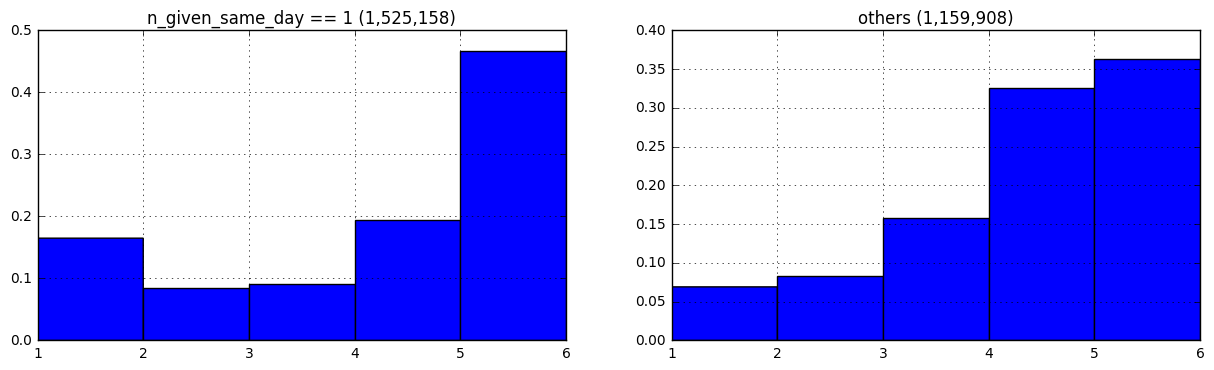

In [26]:
compare_star_distribution(reviews, 'n_given_same_day == 1')

So it _appears_ that users who only review a single business in a day are more likely to give 5s or 1s, which I'm tempted to say is because they logged on to Yelp specifically because they had just gone to that establishment and either loved it or hated it. However, let's see if there are any differences in the distribution based on other splits:

1 star % for month == 12 is 0.13 vs. 0.12 for others (difference of 3.3%)
2 star % for month == 12 is 0.08 vs. 0.08 for others (difference of 1.5%)
3 star % for month == 12 is 0.12 vs. 0.12 for others (difference of 3.7%)
4 star % for month == 12 is 0.25 vs. 0.25 for others (difference of 1.3%)
5 star % for month == 12 is 0.41 vs. 0.42 for others (difference of -3.2%)


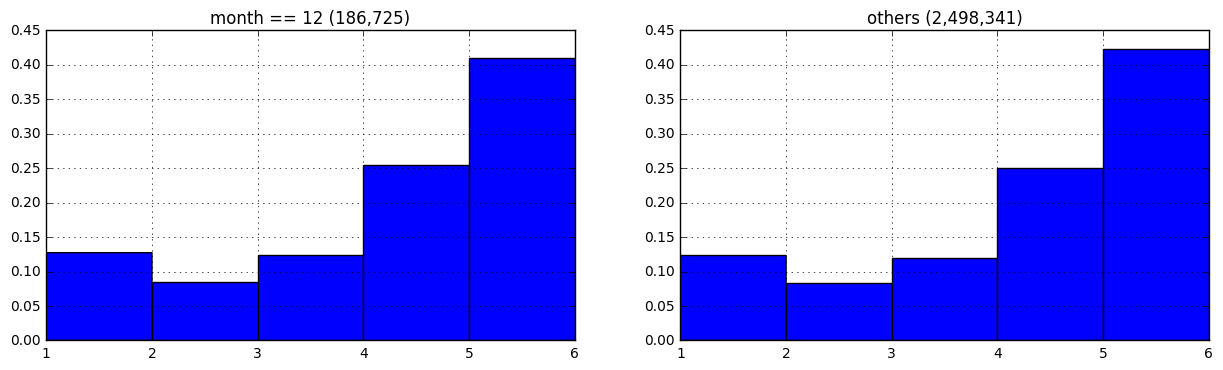

In [27]:
compare_star_distribution(reviews, 'month == 12')

No significant difference for December. Let's try looking at the year:

1 star % for year < 2012 is 0.07 vs. 0.13 for others (difference of -57.5%)
2 star % for year < 2012 is 0.09 vs. 0.08 for others (difference of 13.5%)
3 star % for year < 2012 is 0.17 vs. 0.11 for others (difference of 44.1%)
4 star % for year < 2012 is 0.35 vs. 0.23 for others (difference of 41.1%)
5 star % for year < 2012 is 0.31 vs. 0.45 for others (difference of -34.7%)


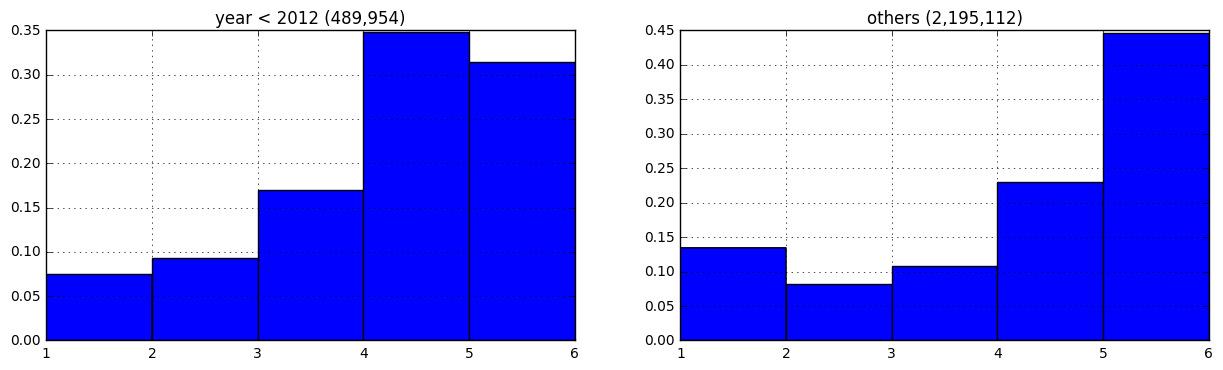

In [28]:
compare_star_distribution(reviews, 'year < 2012')

Now that's interesting -- the distribution is very different before and after 2012. Let's take a look at this in greater depth:

In [24]:
min_date = reviews['date'].min()
max_date = reviews['date'].max()

dates = []
stars = [[],[],[],[],[]]
for year in range(min_date.year, max_date.year + 1):
    for month in range(1, 13):
        df = reviews.query('year == {} & month == {}'.format(year, month))
        if not len(df):
            continue
        dates.append(pd.to_datetime(year*10000+month*100+1,format='%Y%m%d'))
        for s in [1,2,3,4,5]:
            stars[s-1].append(len(df[df['stars']==s])/float(len(df)))

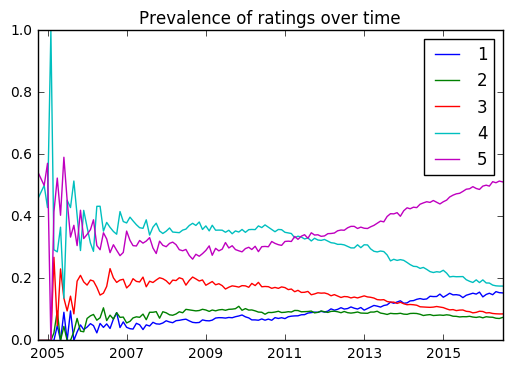

In [70]:
plt.title('Prevalence of ratings over time')
for s in [1,2,3,4,5]:
    plt.plot(dates, stars[s-1],label=str(s))
plt.legend(loc='best')
plt.show()

Whoa. Interesting. The relative percentage of 5s (and 1s) increases a lot the further we move in time. This could be an indication of changing user habits, although I also wonder if it could be due to business owners gaming the system by giving five-star reviews to themselves (and giving one-star reviews to their competitors). In any case, there's something to be explained here.

Let's see how this trend relates to our previous hypothesis about the number of reviews given on the same day being an influencing factor:

1 star % for n_given_same_day == 1 is 0.18 vs. 0.08 for others (difference of 78.6%)
2 star % for n_given_same_day == 1 is 0.08 vs. 0.07 for others (difference of 5.5%)
3 star % for n_given_same_day == 1 is 0.08 vs. 0.14 for others (difference of -56.6%)
4 star % for n_given_same_day == 1 is 0.16 vs. 0.29 for others (difference of -58.7%)
5 star % for n_given_same_day == 1 is 0.51 vs. 0.42 for others (difference of 17.7%)


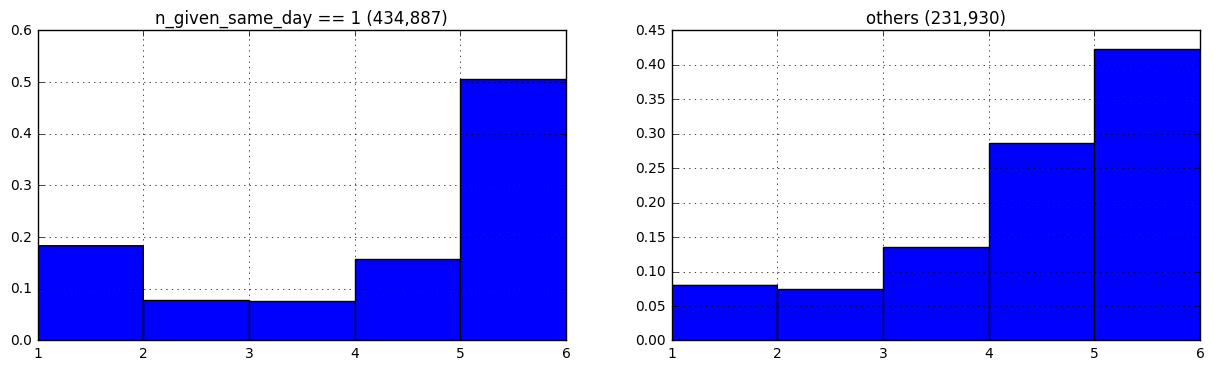

In [29]:
compare_star_distribution(reviews[reviews['year'] == 2015], 'n_given_same_day == 1')

Ok, so we still see a difference in user behavior even when we condition on the year, which I think suggests that users who are only giving one review on a given day really do behave differently. Perhaps the change in ratings over time can be explained by an increase in number of users who only give one review:

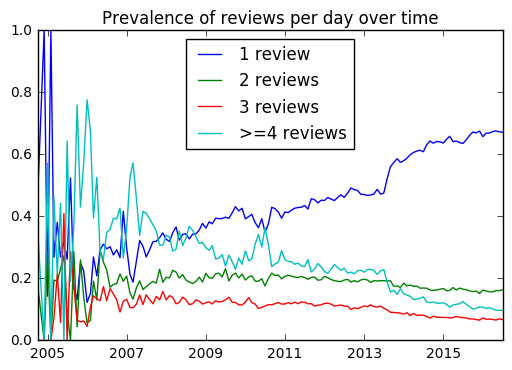

In [84]:
n_given_over_time = [[],[],[],[]]
for year in range(min_date.year, max_date.year + 1):
    for month in range(1, 13):
        df = reviews.query('year == {} & month == {}'.format(year, month))
        if not len(df):
            continue
        n_given_over_time.append(df['n_given_same_day'].mean())
        for n in [1,2,3]:
            n_given_over_time[n-1].append(len(df[df['n_given_same_day']==n])/float(len(df)))
        n_given_over_time[3].append(len(df[df['n_given_same_day']>=4])/float(len(df)))

plt.plot(dates, n_given_over_time[0], label='1 review')
plt.plot(dates, n_given_over_time[1], label='2 reviews')
plt.plot(dates, n_given_over_time[2], label='3 reviews')
plt.plot(dates, n_given_over_time[3], label='>=4 reviews')
plt.legend(loc='best')
plt.title('Prevalence of reviews per day over time')
plt.show()

So it looks like there are more and more users only giving a single review in a day, and that could be an explanation for why the distribution of ratings changes over time. However, that says very little about causality, and if you glance back at the previous plot, the percentage of 5s only starts increasing around 2009, whereas above, the percentage of users just giving one review starts increasing a little sooner. So it's possible that # reviews per day isn't really a causal explanation, but is just correlated with the causal factor (like bot reviews, or at least shifting cultural expectations to give 5s/1s). Let's just check to see how much of a difference there was early on:

1 star % for n_given_same_day == 1 is 0.08 vs. 0.05 for others (difference of 35.7%)
2 star % for n_given_same_day == 1 is 0.09 vs. 0.09 for others (difference of -4.4%)
3 star % for n_given_same_day == 1 is 0.17 vs. 0.21 for others (difference of -21.7%)
4 star % for n_given_same_day == 1 is 0.34 vs. 0.37 for others (difference of -8.0%)
5 star % for n_given_same_day == 1 is 0.32 vs. 0.27 for others (difference of 16.9%)


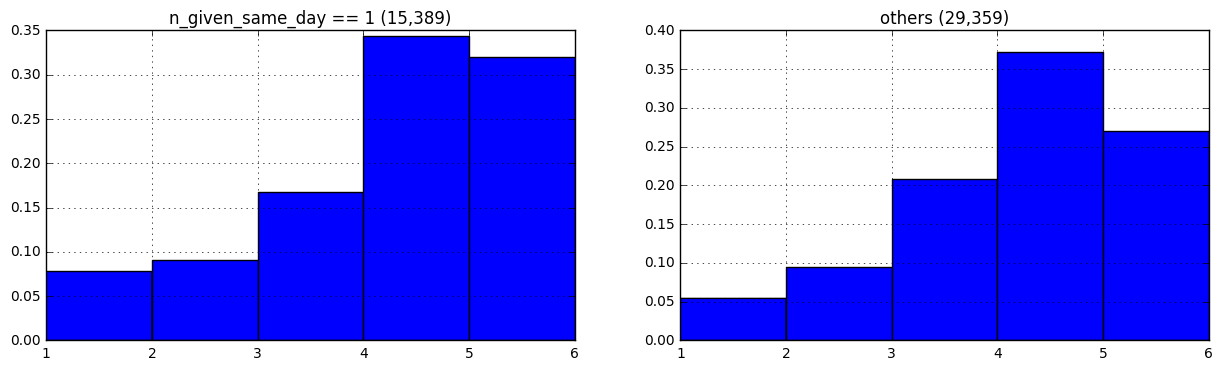

In [30]:
compare_star_distribution(reviews[reviews['year'] == 2008], 'n_given_same_day == 1')

Well, even early on, there are still significantly more 1s and 5s, so I guess I am inclined to believe the effect is real. People have gotten a lot less likely to give 4s, though.

Let's see if the distribution changes when we condition on the number of fans:

In [12]:
users = load_yelp_dataframe('users')

In [14]:
reviews['user_fans'] = [users['fans'][user_id] for user_id in reviews['user_id']]

In [15]:
reviews.head(5)

,user_id,business_id,year,month,day,stars,date,n_given_same_day,weekday,user_fans
0,511457,0,2012,8,1,4,2012-08-01,3,2,0
1,291005,0,2014,2,13,5,2014-02-13,1,3,0
2,551917,0,2015,10,31,5,2015-10-31,3,5,2
3,307072,0,2015,12,26,3,2015-12-26,1,5,0
4,658212,0,2016,4,8,2,2016-04-08,1,4,1


1 star % for user_fans > 50 is 0.03 vs. 0.13 for others (difference of -125.9%)
2 star % for user_fans > 50 is 0.08 vs. 0.08 for others (difference of -9.6%)
3 star % for user_fans > 50 is 0.23 vs. 0.12 for others (difference of 65.2%)
4 star % for user_fans > 50 is 0.42 vs. 0.25 for others (difference of 52.4%)
5 star % for user_fans > 50 is 0.25 vs. 0.43 for others (difference of -53.5%)


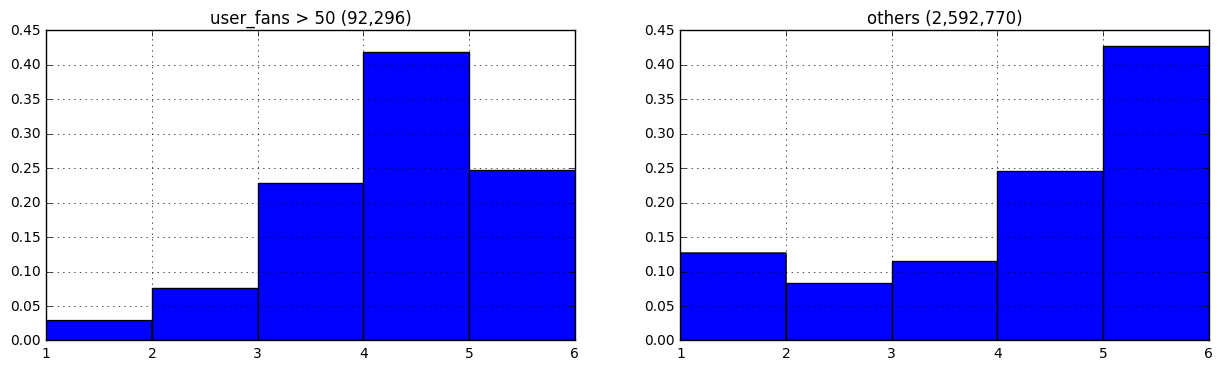

In [31]:
compare_star_distribution(reviews, 'user_fans > 50')

So users with more fans seem to give markedly different reviews. That's interesting. I wonder how much of that difference is concentrated in users with 0 fans (who could be bots):

1 star % for user_fans == 0 is 0.17 vs. 0.07 for others (difference of 78.4%)
2 star % for user_fans == 0 is 0.08 vs. 0.09 for others (difference of -4.5%)
3 star % for user_fans == 0 is 0.08 vs. 0.16 for others (difference of -70.2%)
4 star % for user_fans == 0 is 0.18 vs. 0.33 for others (difference of -57.2%)
5 star % for user_fans == 0 is 0.49 vs. 0.35 for others (difference of 32.6%)


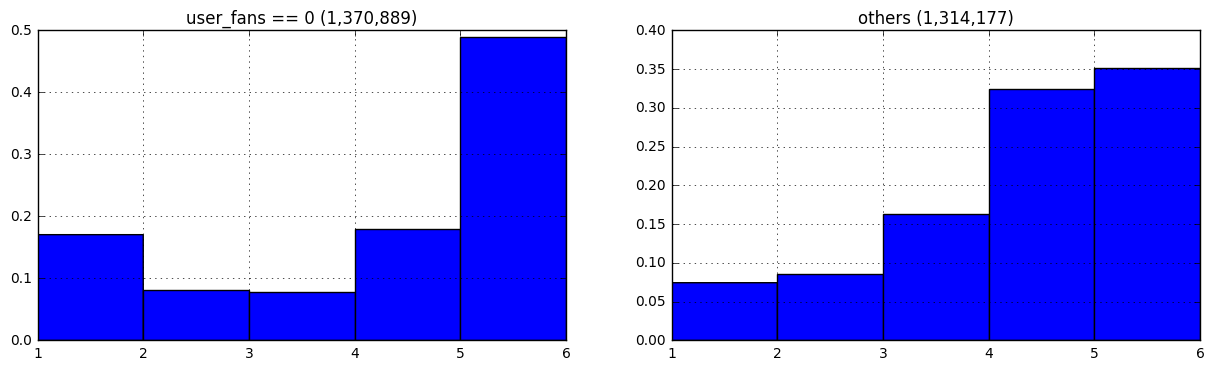

In [32]:
compare_star_distribution(reviews, 'user_fans == 0')

Whoa. Ok. Users with no fans at all tend to give much more extreme reviews than everyone else. That could be more closely related to the real explanatory factor. Although what happens if we condition on number of fans being zero?



************* For users with no fans *************

1 star % for n_given_same_day == 1 is 0.20 vs. 0.10 for others (difference of 68.2%)
2 star % for n_given_same_day == 1 is 0.08 vs. 0.08 for others (difference of 0.9%)
3 star % for n_given_same_day == 1 is 0.06 vs. 0.11 for others (difference of -56.7%)
4 star % for n_given_same_day == 1 is 0.14 vs. 0.27 for others (difference of -60.8%)
5 star % for n_given_same_day == 1 is 0.51 vs. 0.44 for others (difference of 14.6%)


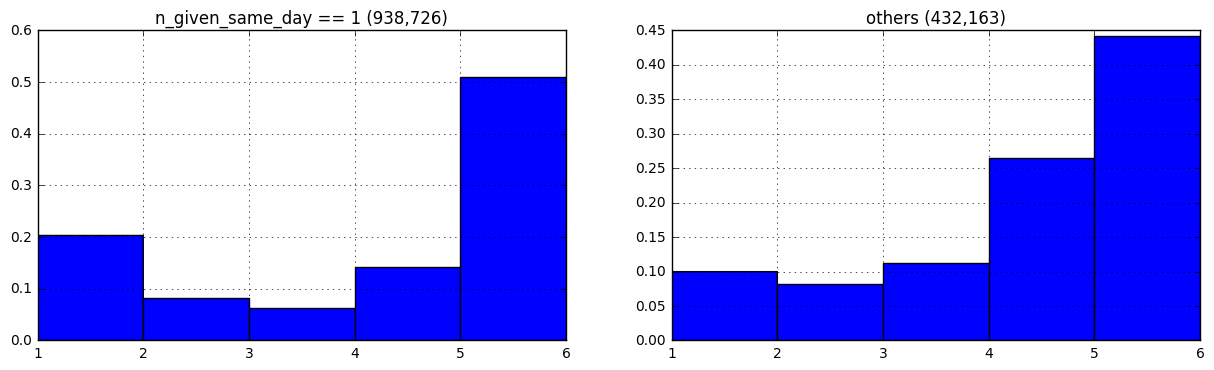



************* For users with >10, <=50 fans *************

1 star % for n_given_same_day == 1 is 0.05 vs. 0.04 for others (difference of 37.9%)
2 star % for n_given_same_day == 1 is 0.09 vs. 0.08 for others (difference of 1.1%)
3 star % for n_given_same_day == 1 is 0.19 vs. 0.22 for others (difference of -12.8%)
4 star % for n_given_same_day == 1 is 0.37 vs. 0.39 for others (difference of -7.7%)
5 star % for n_given_same_day == 1 is 0.30 vs. 0.27 for others (difference of 13.3%)


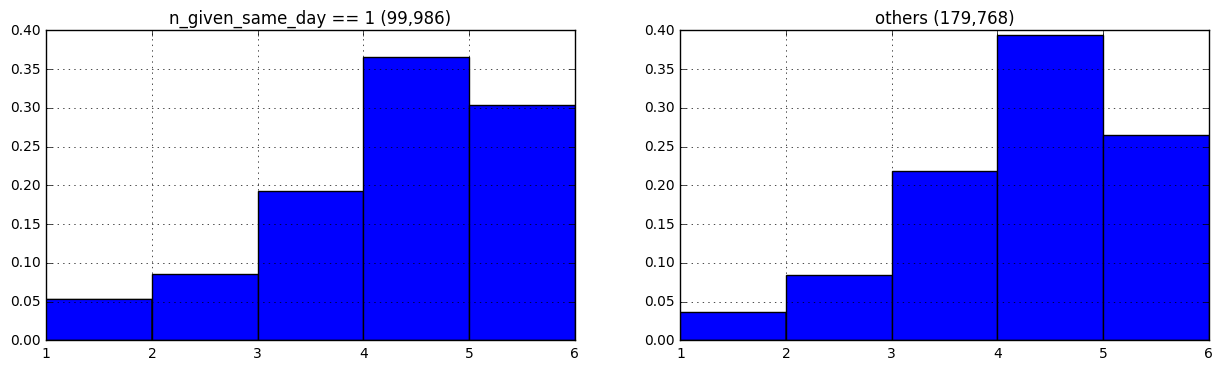



************* For users with >50 fans *************

1 star % for n_given_same_day == 1 is 0.03 vs. 0.03 for others (difference of 10.3%)
2 star % for n_given_same_day == 1 is 0.07 vs. 0.08 for others (difference of -14.2%)
3 star % for n_given_same_day == 1 is 0.21 vs. 0.24 for others (difference of -16.8%)
4 star % for n_given_same_day == 1 is 0.42 vs. 0.42 for others (difference of -0.4%)
5 star % for n_given_same_day == 1 is 0.27 vs. 0.23 for others (difference of 18.7%)


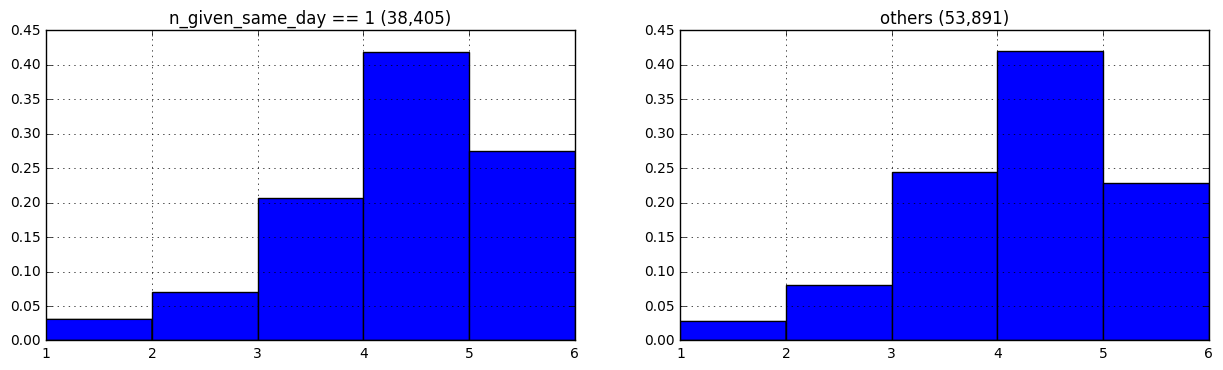

In [43]:
print('\n\n************* For users with no fans *************\n')
compare_star_distribution(reviews.query('user_fans == 0'), 'n_given_same_day == 1')
print('\n\n************* For users with >10, <=50 fans *************\n')
compare_star_distribution(reviews.query('10 < user_fans <= 50'), 'n_given_same_day == 1')
print('\n\n************* For users with >50 fans *************\n')
compare_star_distribution(reviews.query('user_fans > 50'), 'n_given_same_day == 1')

The increased-5s/1s-when-only-giving-one-review effect is less strong the more fans a user has, but still present.